In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

# Jupyter settings
%matplotlib inline
sns.set(style="whitegrid")


In [3]:
# Load cleaned data
file_path = '../data/cleaned_avian_data.csv'
data = pd.read_csv(file_path)

# Preview
display(data.head())

,Year,Month,Region,Diagnoses,Case count,Season,Month_Num,Last_Month_Case_Count,Last_Year_Same_Month,Date
0,2020,March,East Midlands,"Coccidiosis, Helminthosis",3,Autumn,3,0,0,2020-03-01
1,2021,April,East Midlands,"Egg peritonitis and salpingitis, Infectious br...",6,Autumn,4,3,0,2021-04-01
2,2022,October,East Midlands,Marek's Disease,1,Spring,10,6,0,2022-10-01
3,2023,March,East Midlands,"Egg peritonitis and salpingitis, Marek's Disea...",3,Autumn,3,1,3,2023-03-01
4,2023,April,East Midlands,"Neoplasm (other, including adenocarcinoma)",1,Autumn,4,3,6,2023-04-01


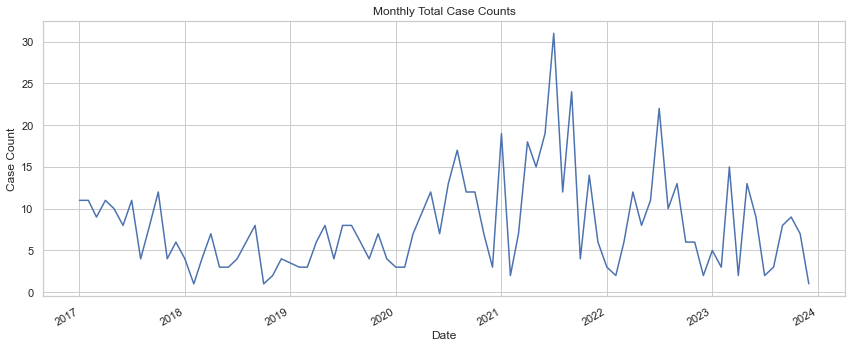

In [5]:
# 4. Create a Date Column for Time Series
data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Month_Num'].astype(str), format='%Y-%m')

# Time trend: Total case count over time
monthly_trend = data.groupby('Date')['Case count'].sum()

plt.figure(figsize=(12, 5))
monthly_trend.plot()
plt.title('Monthly Total Case Counts')
plt.ylabel('Case Count')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

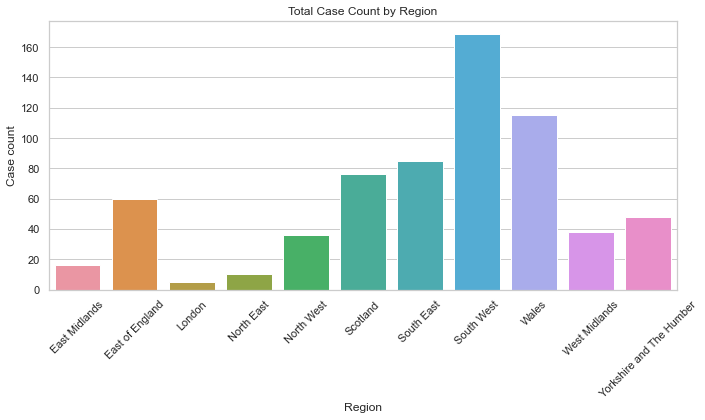

In [6]:
# Case count by Region
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='Region', y='Case count', estimator=sum, ci=None)
plt.xticks(rotation=45)
plt.title('Total Case Count by Region')
plt.tight_layout()
plt.show()


In [7]:
# Split the comma-separated diagnoses and flatten the list
all_diagnoses = data['Diagnoses'].dropna().apply(lambda x: [d.strip() for d in x.split(',')])

# Flatten the list and get unique values
diagnosis_list = sorted(set([diag for sublist in all_diagnoses for diag in sublist]))

# Display
print(f"Total unique diagnoses: {len(diagnosis_list)}")
for diag in diagnosis_list:
    print(diag)


Total unique diagnoses: 110
Abnormal faeces or other GIT
Adverse environment
All
Amyloidosis
Blackhead
Broiler ascites
Cardiomyopathy and heart failure (other)
Cellulitis (usually E.coli
Chronic congestive heart failure
Coccidiosis
Coccidiosis - Eimeria acervulina in chickens
Coccidiosis - Eimeria necatrix in chickens
Coccidiosis - Eimeria tenella in chickens
Colibacillosis
Coligranuloma
Colisepticaemia
Curled toe paralysis / riboflavin deficiency
Diagnosis: Mycotic pneumonia Mycotic pneumonia or airsacculitis
Ectoparasite
Ectoparasites
Egg peritonitis and salpingitis
Enteritis NOS
Enterococcal infection
Fatty liver haem syndrome of layer chickens
Fatty liver haemorrhagic syndrome of layer chickens
Femoral head necrosis
Found dead
Fowl pox (avian pox)
Fungal infections (not otherwise specified)
Gizzard erosion - NOS
Gizzard erosion due to Adenovirus
Helminthosis
IBV/Gumboro
Idiopathic peripheral neuropathy of layers in r...
Impactions
Infectious bronchitis
Infectious coryza (Avibacteri

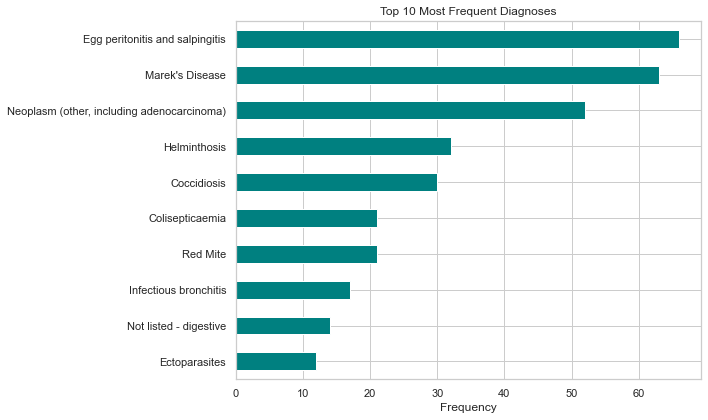

In [8]:
import re

# Function to split by commas outside parentheses
def smart_split(text):
    return [s.strip() for s in re.split(r',\s*(?![^()]*\))', text)]

# Apply the split
diagnosis_series = data['Diagnoses'].dropna().apply(smart_split)

# Flatten list
flat_diagnoses = [d for sublist in diagnosis_series for d in sublist]

# Count frequency
diagnosis_counts = pd.Series(Counter(flat_diagnoses)).sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
diagnosis_counts.plot(kind='barh', color='teal')
plt.title("Top 10 Most Frequent Diagnoses")
plt.xlabel("Frequency")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

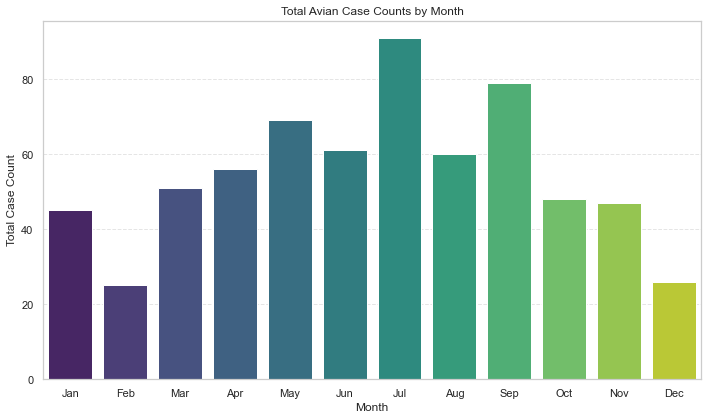

In [9]:
# 7. Seasonal Case Patterns

# Group by month number and sum the case counts
monthly_case_counts = data.groupby('Month_Num')['Case count'].sum().reindex(range(1, 13))

# Define month labels
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=month_labels, y=monthly_case_counts.values, palette='viridis')

plt.title('Total Avian Case Counts by Month')
plt.xlabel('Month')
plt.ylabel('Total Case Count')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



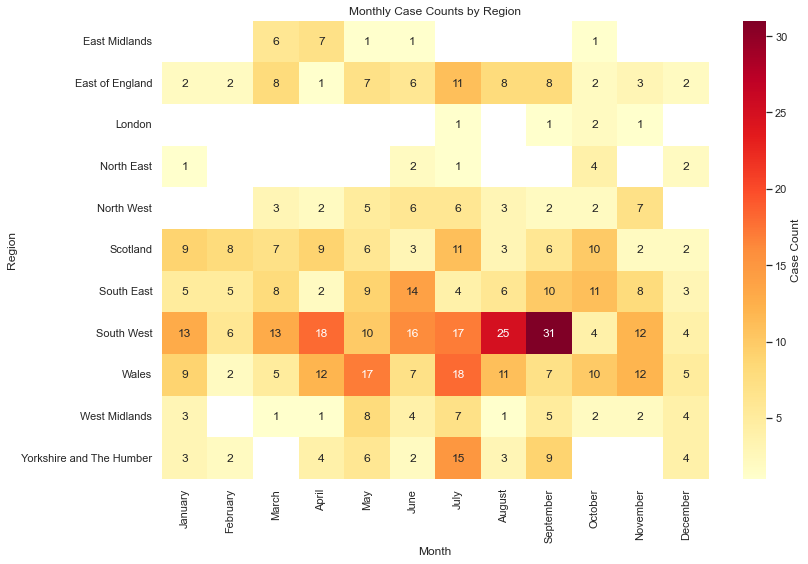

In [10]:
# Aggregate total case counts by Region and Month
region_month_cases = data.groupby(['Region', 'Month_Num'])['Case count'].sum().reset_index()

# To plot in calendar order, sort by Month_Num
region_month_cases['Month_Name'] = region_month_cases['Month_Num'].apply(lambda x: pd.to_datetime(str(x), format='%m').strftime('%B'))

# Pivot for heatmap: Regions as rows, Months as columns
heatmap_data = region_month_cases.pivot(index='Region', columns='Month_Name', values='Case count')

# Sort columns by month order
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
                'August', 'September', 'October', 'November', 'December']
heatmap_data = heatmap_data[months_order]

# Plot heatmap to visualize critical months per region
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='YlOrRd', cbar_kws={'label': 'Case Count'})
plt.title('Monthly Case Counts by Region')
plt.ylabel('Region')
plt.xlabel('Month')
plt.tight_layout()
plt.show()

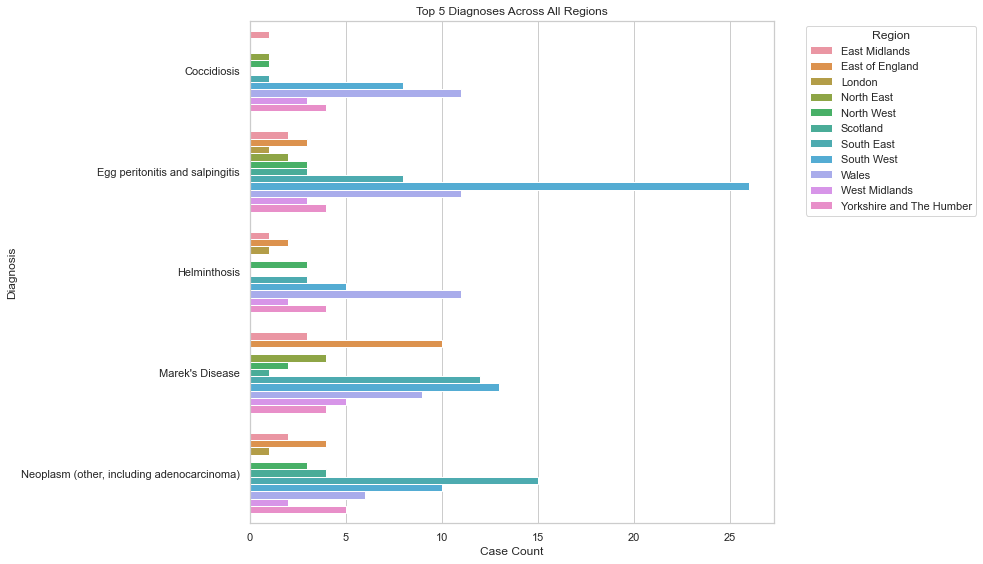

In [11]:

# Function to split diagnoses smartly (avoids splitting inside parentheses)
def smart_split(text):
    return [s.strip() for s in re.split(r',\s*(?![^()]*\))', text)]

# Step 1: Expand Diagnoses
data_expanded = data[['Region', 'Diagnoses']].dropna().copy()
data_expanded['Diagnosis_List'] = data_expanded['Diagnoses'].apply(smart_split)
data_expanded = data_expanded.explode('Diagnosis_List')

# Step 2: Get Top 5 Diagnoses (Overall)
top5_diagnoses = (
    data_expanded['Diagnosis_List']
    .value_counts()
    .head(5)
    .index
    .tolist()
)

# Step 3: Filter Data to Include Only Top 5 Diagnoses
filtered_data = data_expanded[data_expanded['Diagnosis_List'].isin(top5_diagnoses)]

# Step 4: Count by Region and Diagnosis
region_diag_counts = (
    filtered_data
    .groupby(['Region', 'Diagnosis_List'])
    .size()
    .reset_index(name='Count')
)

# Step 5: Plot
plt.figure(figsize=(14, 8))
sns.barplot(data=region_diag_counts, x='Count', y='Diagnosis_List', hue='Region', dodge=True)
plt.title("Top 5 Diagnoses Across All Regions")
plt.xlabel("Case Count")
plt.ylabel("Diagnosis")
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Data types:
 Year                       int64
Month                     object
Region                    object
Diagnoses                 object
Case count                 int64
Season                    object
Month_Num                  int32
Last_Month_Case_Count      int64
Last_Year_Same_Month       int64
Date                      object
Avg_Temp_C               float64
dtype: object

Shape: (274, 11)

Null values per column:
 Year                     0
Month                    0
Region                   0
Diagnoses                0
Case count               0
Season                   0
Month_Num                0
Last_Month_Case_Count    0
Last_Year_Same_Month     0
Date                     0
Avg_Temp_C               0
dtype: int64

Summary statistics:
               Year  Case count   Month_Num  Last_Month_Case_Count  \
count   274.000000  274.000000  274.000000             274.000000   
mean   2020.255474    2.401460    6.675182               2.346715   
std       2.003766    1.959

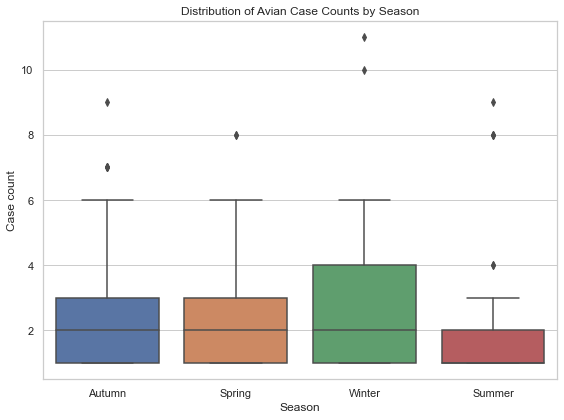

In [14]:


# Load the cleaned dataset with weather information
df = pd.read_csv("../data/cleaned_avian_with_weather.csv")

# Ensure Month_Num is integer
df["Month_Num"] = df["Month_Num"].astype(int)

# Display column types
print("Data types:\n", df.dtypes)

# Shape of the dataset
print("\nShape:", df.shape)

# Null values
print("\nNull values per column:\n", df.isnull().sum())

# Summary statistics
print("\nSummary statistics:\n", df.describe())


# --- Boxplot: Case count by Season ---
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Season', y='Case count')
plt.title('Distribution of Avian Case Counts by Season')
plt.tight_layout()
plt.show()
